# NCF Recommender System with PyTorch: A Deep Dive 🚀
This notebook delves into the exciting world of recommender systems using Neural Collaborative Filtering (NCF) implemented in PyTorch. We'll explore various aspects, including handling both explicit and implicit user feedback scenarios (Where explicit scenario is a regression task and implicit scenario is a classification task), building an end-to-end recommender system pipeline, and leveraging the power of deep learning to generate personalized recommendations.

# Understanding NCF:
NCF, introduced by Xiangnan He et al. in their influential paper [Neural Collaborative Filtering](https://arxiv.org/abs/1708.05031), offers a powerful framework for collaborative filtering. It encompasses a range of models built upon multi-layer perceptrons, effectively generalizing matrix factorization techniques.

<div style="text-align:center;">
    <img src="https://www.adityaagrawal.net/blog/assets/dnn/ncf.png" alt="Image" width="600" height="400">
</div>

# Adjusted Architecture:
The original NCF model takes user and item IDs as input and concatenates their embeddings to form the input layer, which is more vulnerable to the well-known cold-start problem. However, in this notebook, we'll modify the architecture to include additional user and item features. This allows us to handle both explicit and implicit feedback scenarios effectively.

<div style="text-align:center;">
    <img src="utils/img/NCF.png" alt="Image" width="900" height="400">
</div>

This adjusted architecture comprises the following components:
1. **User and Item Embeddings:** These embeddings capture the latent features of users and items, enabling the model to learn their interactions effectively. (As before)
2. **User and Item Features:** These features provide additional information about users and items, enhancing the model's understanding of their characteristics. (User demographics, item genres, etc.)
3. **Fully Connected Layers:** These layers are used to transform the feature vectors into the same size as the embeddings, facilitating their concatenation in the subsequent layers (MLP).

## Exploring the Code:

For a practical implementation, you can refer to the GitHub repository:
[NCF-Recommender-System](https://github.com/oyounis19/NCF-Recommender-System)

## Demystifying the Recommender System Pipeline:
<figure>
  <center>
    <div style="width:940px;height:500px;">
      <img src="https://miro.medium.com/v2/resize:fit:1400/format:png/0*M-kqT5K4y1fSjRY6" alt="Recommender System Pipeline" style="width:100%;height:100%;">
    </div>
    <!-- Credit for the image -->
    <figcaption>Image from this article</figcaption><a href="https://medium.com/nvidia-merlin/recommender-systems-not-just-recommender-models-485c161c755e">Recommender Systems: Not Just Recommender Models</a>
  </center>
</figure>

Let's dissect the key stages involved in generating personalized recommendations:
1. **Retrieval: Selecting the Right Candidates**
- This initial phase involves narrowing down the vast item catalog to a manageable set of potential recommendations. Several techniques can be employed:    
    - **Popularity-Based:** Prioritize items with high overall user engagement.
    - **Content-Based:** Recommend items similar to the user's past preferences.
    - **Collaborative Filtering:** Suggest items enjoyed by users with similar tastes.
    - **Hybrid Approaches:** Combine multiple retrieval strategies for a more comprehensive approach. (Implemented in this notebook)
2. **Filtering: Refining the Set**
- Ensure the candidate list is relevant and appropriate for the user. This might involve:
    - Removing items the user has already interacted with. (Implemented in this notebook)
    - Excluding items unavailable in the user's region.
    - Filtering out items unsuitable based on age restrictions.
3. **Scoring: Prioritizing Recommendations**
- Here, the remaining candidates are ranked based on their predicted relevance to the user. Popular techniques include:
    - Neural Collaborative Filtering (NCF) models (as demonstrated in this notebook)
    - Matrix Factorization
    - BST (Behavior Sequence Transformer) models (e.g., [BST in Alibaba](https://arxiv.org/abs/1905.06874))
    - BERT4Rec models (e.g., [BERT4Rec](https://arxiv.org/abs/1904.06690))
4. **Ordering: Presenting the Final Recommendations**
- This final stage incorporates business logic to determine the order in which items are presented. Examples include:
    - Displaying the top 10 most relevant items. (Implemented in this notebook)
    - Highlighting items currently on sale.
    - Prioritizing in-stock items for immediate purchase.

By understanding these stages and the power of NCF, we can create robust and personalized recommender systems that enhance user experiences.

In [1]:
import pandas as pd
from IPython.display import display
from sklearn.model_selection import train_test_split

import torch
from utils.utils import Utils, EarlyStopping, cols_dict
from utils.model import NCF

# Limit number of printed columns
pd.set_option("display.max_columns", 6)

In [2]:
dir = 'data/ml-1m/'

# Load ratings file
ratings_data = pd.read_csv(dir + 'ratings.dat', sep='::', names=cols_dict['ratings'], engine='python')

# Load users file
users_data = pd.read_csv(dir + 'users.dat', sep='::', names=cols_dict['users'], engine='python')

# Load items file
items_data = pd.read_csv(dir + 'movies.dat', sep='::', names=cols_dict['items'], encoding='latin-1', engine='python')

# Display the first few rows of each dataset
display(ratings_data.head(3), users_data.head(3), items_data.head(3))

ratings_data.shape, users_data.shape, items_data.shape

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968


,user_id,gender,age,occupation,zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117


,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


((1000209, 4), (6040, 5), (3883, 3))

In [3]:
# Copy the original data for future reference
users_data_og = users_data.copy(deep=True); items_data_og = items_data.copy(deep=True); ratings_data_og = ratings_data.copy(deep=True)

# Check for missing values
ratings_data.isnull().sum().sum(), users_data.isnull().sum().sum(), items_data.isnull().sum().sum()

(0, 0, 0)

# Explicit Feedback
- Explicit feedback is when a user gives direct feedback on an item (e.g. rating a movie on a scale of 1 to 5 stars).
- Predict the rating a user will give to a movie they have not yet rated.

## Preprocessing & Feature Extraction

Extracted features:
- Average rating for each category
- Year from the title

In [4]:
# One-hot encode categorical features
users_data = Utils.one_hot_encode(users_data, ['occupation', 'gender', 'age'])

# Multi-hot encode genres
items_data = Utils.multi_hot_encode(items_data, 'genre')

# Features Extraction
users_data = Utils.extract_category_avg_ratings(users_data, items_data, ratings_data)
items_data = Utils.extract_year(items_data)

# Move gender columns to the front
users_data = Utils.move_column(users_data, ['gender_M', 'gender_F'], 0)

# Extend Users and Items data to match the number of rows in the ratings data (Aligned)
users_data, items_data = Utils.extend_users_items(users_data, items_data, ratings_data)

# Drop unnecessary columns
ratings_data = ratings_data.drop(['timestamp'], axis=1) # Explicit Interactions
users_data = users_data.drop(['user_id', 'zip_code'], axis=1) # Demographics
items_data = items_data.drop(['movie_id', 'title'], axis=1)

# Normalize continuous features
ratings_data['rating'] = ratings_data['rating'].astype(float) / 5.0
items_data['year'] = items_data['year'] / items_data['year'].max()
users_data.iloc[:, -18:] = users_data.iloc[:, -18:] / users_data.iloc[:, -18:].max().max()

print("Ratings shape:", ratings_data.shape, "\nUsers shape:", users_data.shape, "\nItems shape:", items_data.shape)

# A quick look at the data
display(ratings_data.head(3), users_data.head(3), items_data.head(3))

Ratings shape: (1000209, 3) 
Users shape: (1000209, 48) 
Items shape: (1000209, 19)


,user_id,movie_id,rating
0,1,1193,1.0
1,1,661,0.6
2,1,914,0.6


,gender_M,gender_F,occupation_0,...,user_avg_rating_Thriller,user_avg_rating_War,user_avg_rating_Western
0,0,1,0,...,0.612114,0.698806,0.0
1,0,1,0,...,0.612114,0.698806,0.0
2,0,1,0,...,0.612114,0.698806,0.0


,Action,Adventure,Animation,...,War,Western,year
0,0,0,0,...,0,0,0.9875
1,0,0,1,...,0,0,0.9980
2,0,0,0,...,0,0,0.9820


## Prepare Data

In [5]:
# users
X_users_train, X_users_test = train_test_split(users_data, test_size=0.2, shuffle=True, random_state=42)
X_users_val, X_users_test = train_test_split(X_users_test, test_size=0.5, shuffle=True, random_state=42)

# items
X_items_train, X_items_test = train_test_split(items_data, test_size=0.2, shuffle=True, random_state=42)
X_items_val, X_items_test = train_test_split(X_items_test, test_size=0.5, shuffle=True, random_state=42)

# ratings
y_ratings_train, y_ratings_test = train_test_split(ratings_data, test_size=0.2, shuffle=True, random_state=42)
y_ratings_val, y_ratings_test = train_test_split(y_ratings_test, test_size=0.5, shuffle=True, random_state=42)

# Convert to NumPy arrays
X_users_train, X_users_val, X_users_test = X_users_train.values, X_users_val.values, X_users_test.values
X_items_train, X_items_val, X_items_test = X_items_train.values, X_items_val.values, X_items_test.values
y_ratings_train, y_ratings_val, y_ratings_test = y_ratings_train.values, y_ratings_val.values, y_ratings_test.values

# Shape of the data
print("Ratings shape:", y_ratings_train.shape, y_ratings_val.shape, y_ratings_test.shape)
print("Users shape:", X_users_train.shape, X_users_val.shape, X_users_test.shape)
print("Items shape:", X_items_train.shape, X_items_val.shape, X_items_test.shape)

Ratings shape: (800167, 3) (100021, 3) (100021, 3)
Users shape: (800167, 48) (100021, 48) (100021, 48)
Items shape: (800167, 19) (100021, 19) (100021, 19)


## Model

In [6]:
user_dim = users_data.shape[1] # 48
item_dim = items_data.shape[1] # 19

num_users = users_data_og['user_id'].max()
num_items = items_data_og['movie_id'].max()

embedding_dim = 32 # number of latent factors

model = NCF(
    num_users=num_users,
    num_items=num_items,
    user_dim=user_dim,
    item_dim=item_dim,
    num_factors=embedding_dim,
    mode='explicit',
    criterion=torch.nn.MSELoss(),
    dropout=0.1,
    lr=1e-3,
    weight_decay=1e-5, # L2 regularization
    verbose=True,
    gpu=True
)

early_stopping = EarlyStopping(patience=3, delta=0.0002, path='weights/explicit.pth') # early stops after 2 consecutive epochs with minor loss decrease/increase
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(model.optimizer, mode='min', factor=0.1, patience=0) # reduces learning rate by factor of 0.1 when no improvement is seen

NCF(
  (user_embedding_mlp): Embedding(6041, 32)
  (item_embedding_mlp): Embedding(3953, 32)
  (user_embedding_mf): Embedding(6041, 32)
  (item_embedding_mf): Embedding(3953, 32)
  (user_features): Sequential(
    (0): Linear(in_features=48, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
  )
  (item_features): Sequential(
    (0): Linear(in_features=19, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
  )
  (MLP): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=128, out_features=32, bias=True)
    (10): ReLU

In [7]:
history = model.fit(
    X=[y_ratings_train[:, 0], y_ratings_train[:, 1], X_users_train, X_items_train],
    y=y_ratings_train[:, 2],
    X_val=[y_ratings_val[:, 0], y_ratings_val[:, 1], X_users_val, X_items_val],
    y_val=y_ratings_val[:, 2],
    epochs=12,
    batch_size=2048,
    early_stopping=early_stopping,
    scheduler=scheduler
)

Epoch 1/12
391/391 - loss: 0.0355 - Val Loss: 0.0325 - R2: 0.3527 - MAE: 0.1425 - MSE: 0.0325 - RMSE: 0.1803 - lr: 0.001
Epoch 2/12
391/391 - loss: 0.0317 - Val Loss: 0.0311 - R2: 0.3809 - MAE: 0.1398 - MSE: 0.0311 - RMSE: 0.1763 - lr: 0.001
Epoch 3/12
391/391 - loss: 0.0301 - Val Loss: 0.0303 - R2: 0.3977 - MAE: 0.1369 - MSE: 0.0303 - RMSE: 0.1739 - lr: 0.001
Epoch 4/12
391/391 - loss: 0.0291 - Val Loss: 0.0299 - R2: 0.4050 - MAE: 0.1368 - MSE: 0.0299 - RMSE: 0.1729 - lr: 0.001
Epoch 5/12
391/391 - loss: 0.0284 - Val Loss: 0.0295 - R2: 0.4128 - MAE: 0.1352 - MSE: 0.0295 - RMSE: 0.1717 - lr: 0.001
Epoch 6/12
391/391 - loss: 0.0278 - Val Loss: 0.0294 - R2: 0.4150 - MAE: 0.1348 - MSE: 0.0294 - RMSE: 0.1714 - lr: 0.001
Epoch 7/12
391/391 - loss: 0.0274 - Val Loss: 0.0292 - R2: 0.4183 - MAE: 0.1355 - MSE: 0.0292 - RMSE: 0.1709 - lr: 0.001
Epoch 8/12
391/391 - loss: 0.0269 - Val Loss: 0.0292 - R2: 0.4182 - MAE: 0.1340 - MSE: 0.0292 - RMSE: 0.1709 - lr: 0.0001
Epoch 9/12
391/391 - loss: 0.02

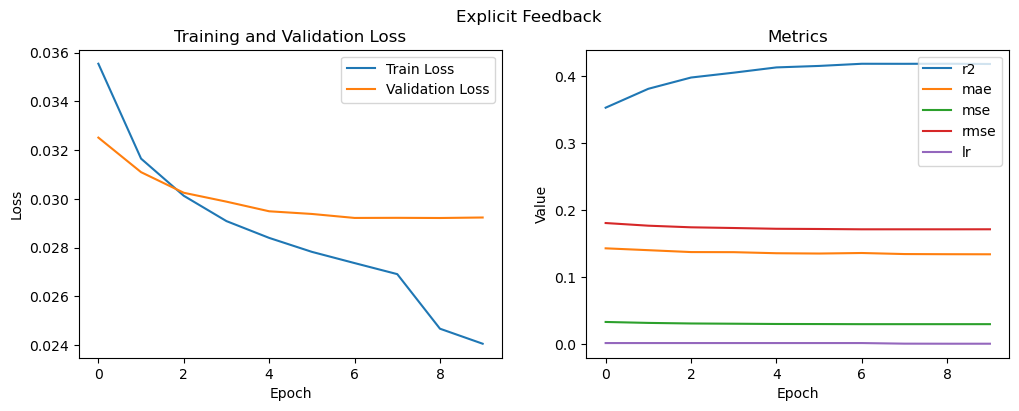

In [8]:
# Plots
Utils.plot_metrics(history, 'Explicit Feedback')

In [9]:
model.eval() # set model to evaluation mode (disables dropout layers)

# Evaluate the model
avg_loss, r2, mae, mse, rmse = model.evaluate([
    y_ratings_test[:, 0],
    y_ratings_test[:, 1],
    X_users_test,
    X_items_test],
    y_ratings_test[:, 2],
    batch_size=256
    )

print(f"Average Loss: {avg_loss:.4f}, R2: {r2:.4f}, MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}")

Average Loss: 0.0295, R2: 0.4119, MAE: 0.1340, MSE: 0.0295, RMSE: 0.1716


## Testing

### New user
**Cold start** problem: When a new user (new user_id) joins the platform, we don't have the embeddings for that user_id (OOV).

Multiple approaches to tackle this:
- Discard the new user_id and **recommend based on the their pre-defined preferences** on sign-up. <span style="color: #da3b3b">(Simple, Ineffective)</span>
- Use the **average of all user embeddings**. <span style="color: #da3b3b">(Simple, Ineffective)</span>
- Add an **extra user_id embedding before training** the model, then assign new users to this embedding. <span style="color: #da3b3b">(Simple, Ineffective)</span>
- Use a **session-based recommendation system** like BST (Behavior Sequence Transformer), GRU4Rec (Gated Recurrent Unit for Session-based Recommendations) till we have enough interactions for that user to train the embeddings. <span style="color: #da703b">(Widely used) (Complex, Effective)</span>
- Use the **average of the embeddings of similar users** e.g. cosine similarity. <span style="color: #52da3b">(Simple, Effective)</span> (We'll use this approach)

In [8]:
new_user = {
    'id': 7000, # new user id
    'age': 20,
    'occupation': 'engineer',
    'gender': 'F',
    'genres': ['Children', 'Comedy', 'Animation'],
}

user_id, user, weights, _ = Utils.preprocess_user(
                                user=new_user,
                                num_items=items_data_og.shape[0],
                                users=users_data.drop_duplicates(inplace=False).values,
                                weights=[model.user_embedding_mlp.weight.data.cpu().numpy(), model.user_embedding_mf.weight.data.cpu().numpy()]
                                )
items = Utils.preprocess_items(items_data_og)

user_id, user = user_id.to(model.device), user.to(model.device)

In [9]:
############### Pipeline ###############

# 1- Retrieval Stage
movies = Utils.retrieve(
    movies=items,
    user=user.detach().cpu().numpy(),
    num_genres=3,
    k=300, # retrieve 300 relevant movies. Note: higher k leads to better recommendations but slower inference
    random_state=0
)

# 2- Filtering Stage
movie_ids, movies = Utils.filter( # Removes already-rated / duplicate movies
    movies=movies,
    ratings=ratings_data_og,
    user_id=new_user['id']
)
movie_ids, movies = movie_ids.to(model.device), movies.to(model.device)

# 3- Ranking Stage
y_pred = model(
    user_id[:len(movies)],
    movie_ids,
    user[:len(movies)],
    movies,
    weights
).cpu().detach().numpy()

# 4- Ordering Stage
movies_retrieved = items_data_og[items_data_og['movie_id'].isin(movie_ids.cpu().numpy())].sort_values(by='movie_id', key=lambda x: pd.Categorical(x, categories=movie_ids.cpu().numpy(), ordered=True))
Utils.order(y_pred, movies_retrieved, 'explicit', top_k=10)

,movie_id,title,genre,predicted_rating
0,1148,"Wrong Trousers, The (1993)",Animation|Comedy,4.33
1,720,Wallace & Gromit: The Best of Aardman Animatio...,Animation,4.27
2,3114,Toy Story 2 (1999),Animation|Children's|Comedy,4.21
3,1,Toy Story (1995),Animation|Children's|Comedy,4.03
4,1223,"Grand Day Out, A (1992)",Animation|Comedy,3.99
5,1136,Monty Python and the Holy Grail (1974),Comedy,3.98
6,2355,"Bug's Life, A (1998)",Animation|Children's|Comedy,3.97
7,3429,Creature Comforts (1990),Animation|Comedy,3.89
8,364,"Lion King, The (1994)",Animation|Children's|Musical,3.86
9,3396,"Muppet Movie, The (1979)",Children's|Comedy,3.86


### Existing user

In [10]:
old_user = {
    'id': 1000
}

# preprocess the old user
user_id, user, _, _ = Utils.preprocess_user(
                                user=old_user,
                                num_items=items_data_og.shape[0],
                                users=users_data.drop_duplicates(inplace=False).values,
                                topk=3, # top 3 genres the user has interacted with. MAX: 18
                                verbose=True
                                )
items = Utils.preprocess_items(items_data_og)

user_id, user = user_id.to(model.device), user.to(model.device)

User id: 1000 top 3 genres: ['Crime' 'Drama' 'War']


In [11]:
############### Pipeline ###############

# 1- Retrieval Stage
movies = Utils.retrieve(
    movies=items,
    user=user.detach().cpu().numpy(),
    k=300, # retrieve 300 relevant movies. Note: higher k leads to better recommendations but slower inference
    random_state=0
)

# 2- Filtering Stage
movie_ids, movies = Utils.filter( # Removes already-rated / duplicate movies
    movies=movies,
    ratings=ratings_data_og,
    user_id=new_user['id']
)
movie_ids, movies = movie_ids.to(model.device), movies.to(model.device)

# 3- Ranking Stage
y_pred = model(
    user_id[:len(movies)],
    movie_ids,
    user[:len(movies)],
    movies
).cpu().detach().numpy()

# 4- Ordering Stage
movies_retrieved = items_data_og[items_data_og['movie_id'].isin(movie_ids.cpu().numpy())].sort_values(by='movie_id', key=lambda x: pd.Categorical(x, categories=movie_ids.cpu().numpy(), ordered=True))
Utils.order(y_pred, movies_retrieved, 'eplicit', top_k=10)

,movie_id,title,genre,predicted_score
0,50,"Usual Suspects, The (1995)",Crime|Thriller,4.78
1,110,Braveheart (1995),Action|Drama|War,4.70
2,1262,"Great Escape, The (1963)",Adventure|War,4.67
3,356,Forrest Gump (1994),Comedy|Romance|War,4.63
4,1242,Glory (1989),Action|Drama|War,4.56
5,1263,"Deer Hunter, The (1978)",Drama|War,4.54
6,912,Casablanca (1942),Drama|Romance|War,4.53
7,1287,Ben-Hur (1959),Action|Adventure|Drama,4.53
8,1224,Henry V (1989),Drama|War,4.52
9,1213,GoodFellas (1990),Crime|Drama,4.51


# Implicit Feedback
- Implicit feedback is when user preferences are inferred from user actions (e.g., clicks, views, purchases).
- Predict the likelihood that a user will interact with an item (e.g., click on a movie).

In [12]:
users_data, items_data, ratings_data = users_data_og, items_data_og, ratings_data_og

## Preprocessing & Feature Extraction
- Here we have to transform the data, MovieLens Dataset, into implicit feedback data (1: interacted, 0: hasn't interacted (by negative sampling))

Extracted features:
- Frequency of interactions per genre
- Year from the title

In [13]:
# One-hot encode categorical features
users_data = Utils.one_hot_encode(users_data, ['occupation', 'gender', 'age'])

# Multi-hot encode genres
items_data = Utils.multi_hot_encode(items_data, 'genre')

# Features Extraction
users_data = Utils.extract_category_freq(users_data, items_data, ratings_data)
items_data = Utils.extract_year(items_data)

# Negative Sampling for implicit feedback
ratings_data = Utils.negative_sampling(ratings_data, items_data, num_negatives=20) # Adds 20 * 6040 rows (num_negatives * num_users) 

# Move gender columns to the front
users_data = Utils.move_column(users_data, ['gender_M', 'gender_F'], 0)

# Extend Users and Items data to match the number of rows in the ratings data
users_data, items_data = Utils.extend_users_items(users_data, items_data, ratings_data)

# Normalize continuous features
items_data['year'] = items_data['year'].astype(float) / items_data['year'].max()

# Drop unnecessary columns
ratings_data = ratings_data.drop(['timestamp'], axis=1) # Implicit Interactions
users_data = users_data.drop(['user_id', 'zip_code'], axis=1) # Demographics
items_data = items_data.drop(['movie_id', 'title'], axis=1)

print("Ratings shape:", ratings_data.shape, "\nUsers shape:", users_data.shape, "\nItems shape:", items_data.shape)

# A quick look at the data
display(ratings_data.head(3), users_data.head(3), items_data.head(3))

Ratings shape: (1121009, 3) 
Users shape: (1121009, 48) 
Items shape: (1121009, 19)


,user_id,movie_id,rating
0,1,1193,1
1,1,661,1
2,1,914,1


,gender_M,gender_F,occupation_0,...,freq_Thriller,freq_War,freq_Western
0,0,1,0,...,0.056604,0.037736,0.0
1,0,1,0,...,0.056604,0.037736,0.0
2,0,1,0,...,0.056604,0.037736,0.0


,Action,Adventure,Animation,...,War,Western,year
0,0,0,0,...,0,0,0.9875
1,0,0,1,...,0,0,0.9980
2,0,0,0,...,0,0,0.9820


## Prepare Data

In [14]:
# ratings
y_ratings_train, y_ratings_test = train_test_split(ratings_data, test_size=0.2, shuffle=True, random_state=42)
y_ratings_val, y_ratings_test = train_test_split(y_ratings_test, test_size=0.5, shuffle=True, random_state=42)

# users
X_users_train, X_users_test = train_test_split(users_data, test_size=0.2, shuffle=True, random_state=42)
X_users_val, X_users_test = train_test_split(X_users_test, test_size=0.5, shuffle=True, random_state=42)

# items
X_items_train, X_items_test = train_test_split(items_data, test_size=0.2, shuffle=True, random_state=42)
X_items_val, X_items_test = train_test_split(X_items_test, test_size=0.5, shuffle=True, random_state=42)

# Convert to NumPy arrays
X_users_train, X_users_val, X_users_test = X_users_train.values, X_users_val.values, X_users_test.values
X_items_train, X_items_val, X_items_test = X_items_train.values, X_items_val.values, X_items_test.values
y_ratings_train, y_ratings_val, y_ratings_test = y_ratings_train.values, y_ratings_val.values, y_ratings_test.values

# Shape of the data
print("Ratings shape:", y_ratings_train.shape, y_ratings_val.shape, y_ratings_test.shape)
print("Users shape:", X_users_train.shape, X_users_val.shape, X_users_test.shape)
print("Items shape:", X_items_train.shape, X_items_val.shape, X_items_test.shape)

Ratings shape: (896807, 3) (112101, 3) (112101, 3)
Users shape: (896807, 48) (112101, 48) (112101, 48)
Items shape: (896807, 19) (112101, 19) (112101, 19)


## Model

In [15]:
user_dim = users_data.shape[1] # 48
item_dim = items_data.shape[1] # 19

num_users = users_data_og['user_id'].max()
num_items = items_data_og['movie_id'].max()

embedding_dim = 32 # number of latent factors

model = NCF(
    num_users=num_users,
    num_items=num_items,
    user_dim=user_dim,
    item_dim=item_dim,
    num_factors=embedding_dim,
    mode='implicit',
    criterion=torch.nn.BCELoss(), # BCELoss since output layer has sigmoid applied to it, otherwise BCEWithLogitsLoss()
    dropout=0.1,
    lr=1e-3,
    weight_decay=1e-5, # L2 regularization
    verbose=True,
    gpu=True
)

early_stopping = EarlyStopping(patience=2, delta=0.001, path='weights/implicit.pth') # early stops after 2 consecutive epochs with minor loss decrease/increase
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(model.optimizer, mode='min', factor=0.1, patience=0) # reduces learning rate by factor of 0.1 when no improvement is seen

NCF(
  (user_embedding_mlp): Embedding(6041, 32)
  (item_embedding_mlp): Embedding(3953, 32)
  (user_embedding_mf): Embedding(6041, 32)
  (item_embedding_mf): Embedding(3953, 32)
  (user_features): Sequential(
    (0): Linear(in_features=48, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
  )
  (item_features): Sequential(
    (0): Linear(in_features=19, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
  )
  (MLP): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=128, out_features=32, bias=True)
    (10): ReLU

In [21]:
history = model.fit(
    X=[y_ratings_train[:, 0], y_ratings_train[:, 1], X_users_train, X_items_train],
    y=y_ratings_train[:, 2],
    X_val=[y_ratings_val[:, 0], y_ratings_val[:, 1], X_users_val, X_items_val],
    y_val=y_ratings_val[:, 2],
    epochs=10,
    batch_size=2048,
    k=10,
    early_stopping=early_stopping,
    scheduler=scheduler
)

Epoch 1/10
438/438 - loss: 0.2265 - Val Loss: 0.1902 - NDCG: 0.9721 - HR: 0.9867 - ROC-AUC: 0.9107 - lr: 0.001
Epoch 2/10
438/438 - loss: 0.1825 - Val Loss: 0.1792 - NDCG: 0.9741 - HR: 0.9867 - ROC-AUC: 0.9213 - lr: 0.001
Epoch 3/10
438/438 - loss: 0.1709 - Val Loss: 0.1760 - NDCG: 0.9743 - HR: 0.9867 - ROC-AUC: 0.9237 - lr: 0.001
Epoch 4/10
438/438 - loss: 0.1610 - Val Loss: 0.1730 - NDCG: 0.9749 - HR: 0.9867 - ROC-AUC: 0.9260 - lr: 0.001
Epoch 5/10
438/438 - loss: 0.1512 - Val Loss: 0.1731 - NDCG: 0.9748 - HR: 0.9867 - ROC-AUC: 0.9267 - lr: 0.0001
Epoch 6/10
438/438 - loss: 0.1269 - Val Loss: 0.1822 - NDCG: 0.9741 - HR: 0.9867 - ROC-AUC: 0.9233 - lr: 1e-05
Early stopping


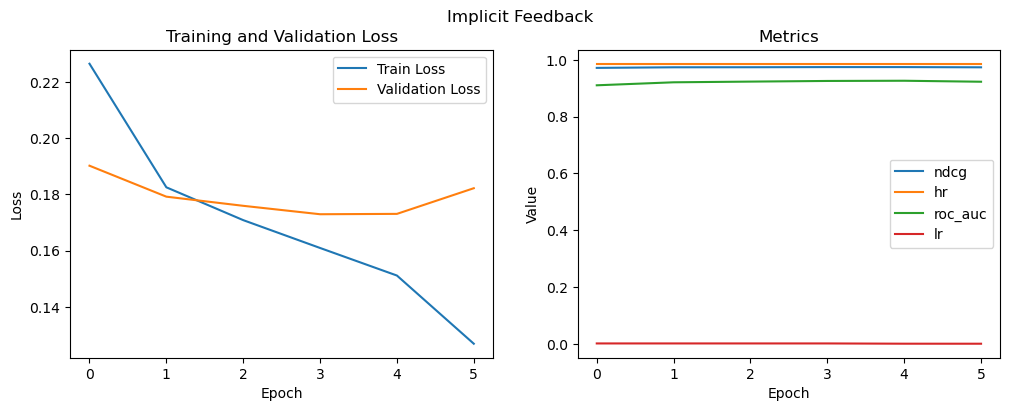

In [22]:
# Plots
Utils.plot_metrics(history, 'Implicit Feedback')

In [23]:
model.eval() # set model to evaluation mode (disables dropout layers)

topk=10

avg_loss, ndcg, hr, auc = model.evaluate([
    y_ratings_test[:, 0],
    y_ratings_test[:, 1],
    X_users_test,
    X_items_test],
    y_ratings_test[:, 2],
    batch_size=256,
    k=topk
)

print(f"Average Loss: {avg_loss:.4f}, NDCG@{topk}: {ndcg:.4f}, HR@{topk}: {hr:.4f}, AUC: {auc:.4f}")

Average Loss: 0.1856, NDCG@10: 0.9732, HR@10: 0.9869, AUC: 0.9222


## Testing

### New User

In [17]:
new_user = {
    'id': 7000, # new user id
    'age': 20,
    'occupation': 'engineer',
    'gender': 'F',
    'genres': ['Children', 'Comedy', 'Animation'],
}

user_id, user, weights, _ = Utils.preprocess_user(
                                user=new_user,
                                num_items=items_data_og.shape[0],
                                users=users_data.drop_duplicates(inplace=False).values,
                                weights=[model.user_embedding_mlp.weight.data.cpu().numpy(), model.user_embedding_mf.weight.data.cpu().numpy()]
                                )
items = Utils.preprocess_items(items_data_og)
items.to_csv('data/items.csv', index=False)
user_id, user = user_id.to(model.device), user.to(model.device)

In [18]:
############### Pipeline ###############

# 1- Retrieval Stage
movies = Utils.retrieve(
    movies=items,
    user=user.detach().cpu().numpy(),
    num_genres=3,
    k=300, # retrieve 300 relevant movies. Note: higher k leads to better recommendations but slower inference
    random_state=0
)

# 2- Filtering Stage
movie_ids, movies = Utils.filter( # Removes already-rated / duplicate movies
    movies=movies,
    ratings=ratings_data_og,
    user_id=new_user['id']
)
movie_ids, movies = movie_ids.to(model.device), movies.to(model.device)

# 3- Ranking Stage
y_pred = model(
    user_id[:len(movies)],
    movie_ids,
    user[:len(movies)],
    movies,
    weights
).cpu().detach().numpy()

# 4- Ordering Stage
movies_retrieved = items_data_og[items_data_og['movie_id'].isin(movie_ids.cpu().numpy())].sort_values(by='movie_id', key=lambda x: pd.Categorical(x, categories=movie_ids.cpu().numpy(), ordered=True))
Utils.order(y_pred, movies_retrieved, 'implicit', top_k=10)

,movie_id,title,genre,predicted_score
0,588,Aladdin (1992),Animation|Children's|Comedy|Musical,1.0
1,3114,Toy Story 2 (1999),Animation|Children's|Comedy,1.0
2,1566,Hercules (1997),Adventure|Animation|Children's|Comedy|Musical,1.0
3,1,Toy Story (1995),Animation|Children's|Comedy,1.0
4,2081,"Little Mermaid, The (1989)",Animation|Children's|Comedy|Musical|Romance,1.0
5,2355,"Bug's Life, A (1998)",Animation|Children's|Comedy,1.0
6,673,Space Jam (1996),Adventure|Animation|Children's|Comedy|Fantasy,1.0
7,2080,Lady and the Tramp (1955),Animation|Children's|Comedy|Musical|Romance,1.0
8,2087,Peter Pan (1953),Animation|Children's|Fantasy|Musical,1.0
9,551,"Nightmare Before Christmas, The (1993)",Children's|Comedy|Musical,1.0


### Existing user

In [19]:
old_user = {
    'id': 4400
}

# preprocess the old user
user_id, user, _, _ = Utils.preprocess_user(
                                user=old_user,
                                num_items=items_data_og.shape[0],
                                users=users_data.drop_duplicates(inplace=False).values,
                                topk=3, # top 3 genres the user has interacted with. MAX: 18
                                verbose=True
                                )
items = Utils.preprocess_items(items_data_og)

user_id, user = user_id.to(model.device), user.to(model.device)

User id: 4400 top 3 genres: ['Romance' 'Drama' 'Comedy']


In [20]:
############### Pipeline ###############

# 1- Retrieval Stage
movies = Utils.retrieve(
    movies=items,
    user=user.detach().cpu().numpy(),
    k=300, # retrieve 300 relevant movies. Note: higher k leads to better recommendations but slower inference
    random_state=0
)

# 2- Filtering Stage
movie_ids, movies = Utils.filter( # Removes already-rated / duplicate movies
    movies=movies,
    ratings=ratings_data_og,
    user_id=new_user['id']
)
movie_ids, movies = movie_ids.to(model.device), movies.to(model.device)

# 3- Ranking Stage
y_pred = model(
    user_id[:len(movies)],
    movie_ids,
    user[:len(movies)],
    movies
).cpu().detach().numpy()

# 4- Ordering Stage
movies_retrieved = items_data_og[items_data_og['movie_id'].isin(movie_ids.cpu().numpy())].sort_values(by='movie_id', key=lambda x: pd.Categorical(x, categories=movie_ids.cpu().numpy(), ordered=True))
Utils.order(y_pred, movies_retrieved, 'implicit', top_k=10)

,movie_id,title,genre,predicted_score
0,356,Forrest Gump (1994),Comedy|Romance|War,0.99
1,11,"American President, The (1995)",Comedy|Drama|Romance,0.98
2,2248,Say Anything... (1989),Comedy|Drama|Romance,0.98
3,2396,Shakespeare in Love (1998),Comedy|Romance,0.98
4,2291,Edward Scissorhands (1990),Drama|Romance,0.98
5,920,Gone with the Wind (1939),Drama|Romance|War,0.98
6,838,Emma (1996),Comedy|Drama|Romance,0.97
7,2406,Romancing the Stone (1984),Action|Adventure|Comedy|Romance,0.97
8,912,Casablanca (1942),Drama|Romance|War,0.97
9,1569,My Best Friend's Wedding (1997),Comedy|Romance,0.96


# Item-to-Item Recommendations
Sometimes, we might want to recommend similar items to a given item. This can be achieved using the item embeddings learned by the model.

**Soon to be implemented ...**